# Example: Sequential simulations, differences between frames
### Explanations for all used functions can be found in the paper

First we need to load all the necessary functions.

In [1]:
from loader import *
from models import *
from utils import *
from plotting import *

The next step is to create a sample of plankton. First we need to decide what type of plankton we want, here we want two different types of spherical plankton. Next we decide the size of the plankton and the size of the image they should be simulated on (in actuality we define the borders of the area the plankton can be initialized in), this is done through the parameters im_size_width, im_size_height, radius1 and radius2. To make the network treat them as two different types of plankton and segment them to different layers of the output later on we also need to assign them labels. One can also make them part of the background if the label is set to -1. In this case we want to track the moving plankton so we create a few stationary ones and assign them the label -1, the slow moving ones (drifting ones) areassigned label 0 and the faster ones are given the label 1. 

In [2]:
im_size_width, im_size_height, radius1, radius2 = 256, 256, 0.15e-6, 0.3e-6



moving_plankton1 = moving_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius1, label=0, diffusion_constant_coeff=1)

stationary_plankton1 = stationary_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius1, label=-1)

moving_plankton2 = moving_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius2, label=1, diffusion_constant_coeff=13)

stationary_plankton2 = stationary_spherical_plankton(
    im_size_height=im_size_height, im_size_width=im_size_width, 
    radius=radius2, label=-1)

When we have created our plankton we need to make them sequential by assigning them a function that updates one of their properties through the images of the sequence. The moving plankton are given helical motion and the stationary plankton are given an update function that returns their previous position.

In [3]:
sequential_moving_plankton1 = Sequential(
    moving_plankton1, position=get_position_moving_plankton)

sequential_stationary_plankton1 = Sequential(
    stationary_plankton1, position=get_position_stationary_plankton)

sequential_moving_plankton2 = Sequential(
    moving_plankton2, position=get_position_moving_plankton)

sequential_stationary_plankton2 = Sequential(
    stationary_plankton2, position=get_position_stationary_plankton)

Then we create the microscope through which the plankton will be sampled. For this we use a brightfield microscope. To create it we need to define the size of the image to be simulated, this is done with im_size_height and im_size_width from the previous step. It is not necessary for the simulated image to be of the same size as the images to be predicted on as will be explained when the network is built. We can also apply a lighting gradient with the parameter gradient_amp, if it is set to 0 there will be no gradient.

In [4]:
gradient_amp=1
microscope = plankton_brightfield(im_size_height, im_size_width, gradient_amp)

Then we can create a sample. If we want the number of plankton to vary on each simulated image we need to create a function that when called generates a random number, we can do this through the use of lambda functions as seen below. The plankton are then raised to the power of these functions to generate many plankton, plankton**4 would create 4 instances of plankton. To create the sample we simply add them together.

In [5]:
no_of_moving_plankton1 = lambda: np.random.randint(50, 100)
no_of_stationary_plankton1 = lambda: np.random.randint(35, 70)
no_of_moving_plankton2 = lambda: np.random.randint(50, 100)
no_of_stationary_plankton2 = lambda: np.random.randint(15, 30)

sample = sequential_moving_plankton1**no_of_moving_plankton1 + \
sequential_stationary_plankton1**no_of_stationary_plankton1 + \
sequential_moving_plankton2**no_of_moving_plankton2 + \
sequential_stationary_plankton2**no_of_stationary_plankton2


Then we add the final properties to the sequence. We can add noise to the images through the parameter noise_amp where a value of 0 means no noise. With the next two parameters, norm_min and norm_max, we can saturate the images to contain both completely white and completely black pixels. To make the images contain very bright pixels we set norm_max to a value larger than 1, and norm_min to less than 0 for very dark pixels.

To create a sequence of images we use the function Sequence() with the abstract sequence as input together with the number of images we want.

After that we plot the sequence. For this cell to generate a new sequence each time we also use imaged_particle_sequence.update().

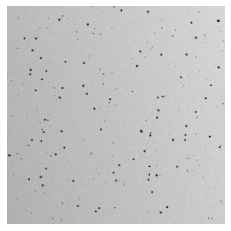

In [6]:
noise_amp, norm_min, norm_max = 1, 0, 1
sequence = create_sequence(noise_amp, sample, microscope, norm_min, norm_max)
sequence_length = 3
imaged_particle_sequence = Sequence(sequence, sequence_length=sequence_length)
imaged_particle_sequence.update()
imaged_particle_sequence.plot(cmap='gray');

To create a training set, we also need labels for our images. For a simulated sequence we use the function get_target_sequence() to create these. If the sequence has different types of plankton, these will be segmented to different layers as seen when we plot the output of the label_function with plot_label. If the sequence contains only one type of plankton the output of the label_function will be three labels the positions of the plankton one each frame. This label_function will later be used in the training.

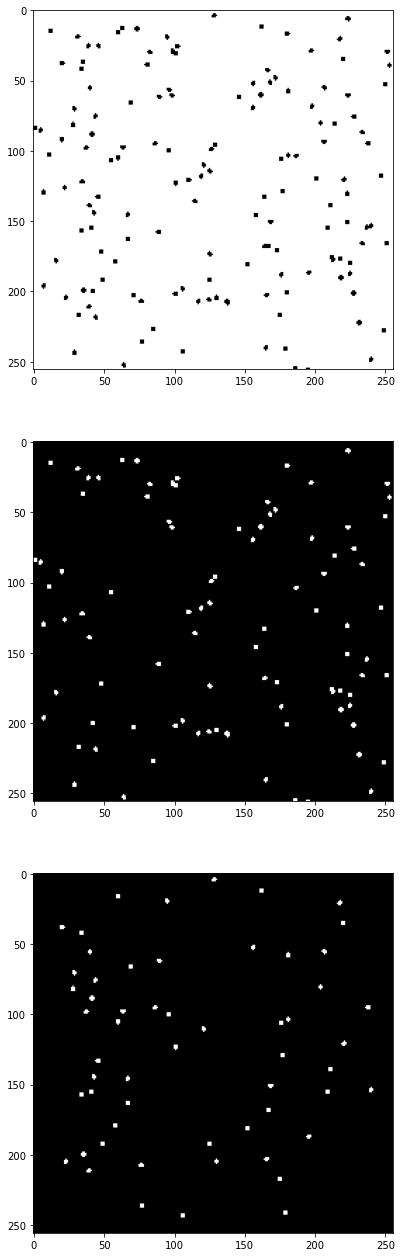

In [7]:
label_function = get_target_sequence
plot_label(label_function, imaged_particle_sequence)

The next step is to create a batch function. The function takes the simulated image(s) and processes them before sending them to the network for training. The first input is the image, the second one is what the output of the batch function should looke like. In this case we use ywo differences between the images as following
 - image0 - image1
 - image1 - image2

In the arguemnt function_img/function_diff we can send a list of functions that will be applied to the images/differences. To view the output of our batch function one can use plot_batch. 

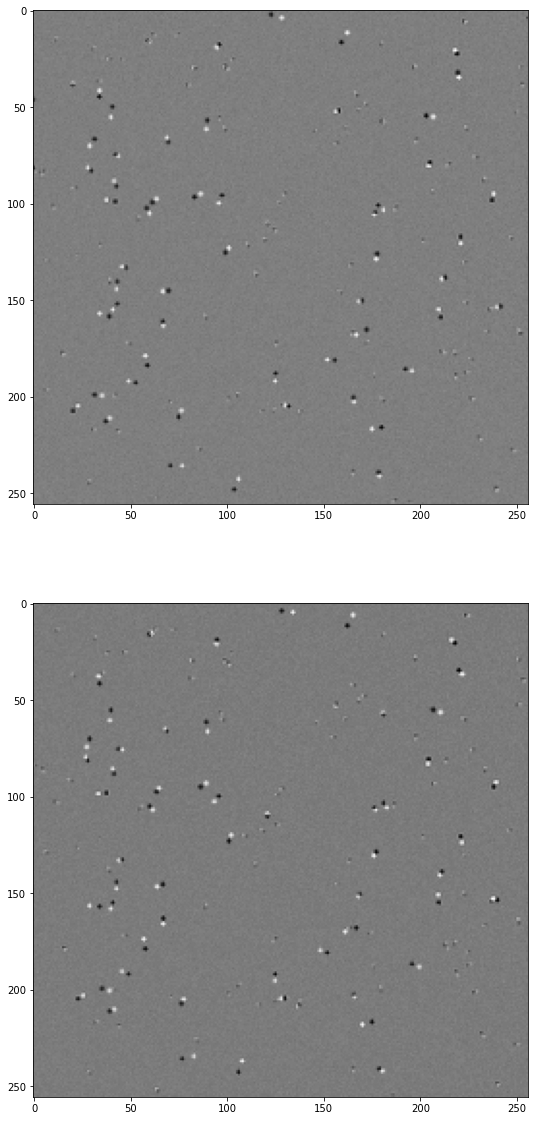

In [8]:
batch_function = create_custom_batch_function(imaged_particle_sequence, 
                                              outputs=[[1,0],[2,1]], 
                                              function_diff=[normalize_image])

plot_batch(imaged_particle_sequence, batch_function)

Now we can create a generator that creates the training data from our simulated image, our label function and our batch function. The continuous generator generates a data set of the defined minimum size before the training starts. It continues to add data to the data set during training until the data size exceeds defined maximum size, then the new data replaces the old data. We also need to define the batch size.

Note that min_data_size needs to be bigger than or equal to the batch_size multiplied with the number of steps_per_epoch defined in the next step.

In [9]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    imaged_particle_sequence,
    get_target_sequence,
    batch_function,
    batch_size=8,
    min_data_size=128,
    max_data_size=512
    )

The last step before starting the training is to define the model. The two Nones are width and height of the images, they don't need to be defined and are better left as Nones if one intends to use the model on differently sized images or images with a different size than the images in the training data. However no_of_inputs and no_of_outputs need to defined, they correspond to the number of images in the input to the network (same as the number of images in the output of the batch_function) and the output of the network (same as the number of images in the output of the label_function).

The training starts by running the function train_model_early_stopping which stops the training early if the performance of the network doesn't improve for a number of epochs. The inputs are the model, the generator and parameters of the training. The patience parameter defines the number of epochs after which the training will stop if no improvements are made. The parameter epochs sets the maximum number of epochs the network will be trained for and steps_per_epoch sets how many batches one epoch will consist of.

In [10]:
no_of_inputs, no_of_outputs = 2, 3
model = generate_unet(None, None, no_of_inputs, no_of_outputs)
model = train_model_early_stopping(model, generator, patience=15, 
                                   epochs=1000, steps_per_epoch=10)

Generating 128 / 128 samples before starting training
Epoch 1/1000
10/10 [==============================] - 1s 80ms/step - loss: 0.0142
Epoch 2/1000
10/10 [==============================] - 1s 93ms/step - loss: 0.0141
Epoch 3/1000
10/10 [==============================] - 1s 88ms/step - loss: 0.0139
Epoch 4/1000
10/10 [==============================] - 1s 86ms/step - loss: 0.0134
Epoch 5/1000
10/10 [==============================] - 1s 78ms/step - loss: 0.0117
Epoch 6/1000
10/10 [==============================] - 1s 89ms/step - loss: 0.0093
Epoch 7/1000
10/10 [==============================] - 1s 101ms/step - loss: 0.0075
Epoch 8/1000
10/10 [==============================] - 1s 87ms/step - loss: 0.0060
Epoch 9/1000
10/10 [==============================] - 1s 87ms/step - loss: 0.0060
Epoch 10/1000
10/10 [==============================] - 1s 82ms/step - loss: 0.0054
Epoch 11/1000
10/10 [==============================] - 1s 81ms/step - loss: 0.0047
Epoch 12/1000
10/10 [====================

When the model is trained one might want to save it to avoid going through this process unnecessarily, this is done with model.save(save path). The save_path_model defines the path to where the network will be saved and with what name.

To load it one uses keras.models.load_model(load path) with the entire path to the model as input. In our case we use a custom defined loss function called softmax_categorical which needs to be added as an input to the function as seen.

In [11]:
# save_path_model = 'E:\\Documents\\models\\diffs.keras'
# model.save(save_path_model)

In [12]:
# load_path_model = 'E:\\Documents\\models\\diffs.keras'
# model = keras.models.load_model(
#     load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

Now to evaluate our model on a frame from our plankton video. To do this we need to feed the images to the network in the way they were fed to it during the training, for this we use the function im_stack. The outputs parameter is set to be identical to the outputs of the batch_function, the path to the folder of the frames is also necessary. The image to be analyzed is assigned through the parameter frame_im0, the image shown will in our case be the 16th image in the folder in alphabetical order. The size of the images when fed to the network is defined in im_size_width and im_size_height. If the images to be analyzed need to be rescaled to a certain size these values are specified in im_resize_width and im_resize_height, if not these values are the dimensions of the image. Usually these two size pairs are equal to eachother. They differ from eachother if one wants to crop the full size image, then im_resize_width and im_resize_height will be the same as the dimensions of the full sized image.

We also have the option to treat the image with a set of functions, these are specified in the function_img/function_diff the same way as in create_custom_batch_function.

When the image is properly prepared we can plot it using plot_image_stack() and see the model's prediction on it using plot_prediction().

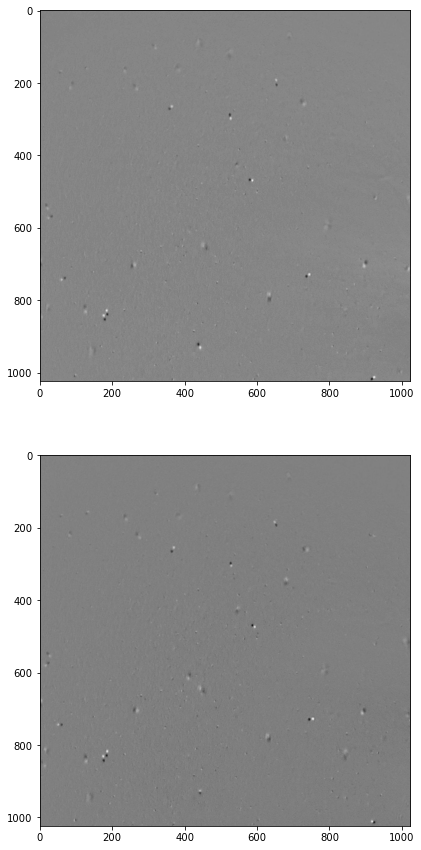

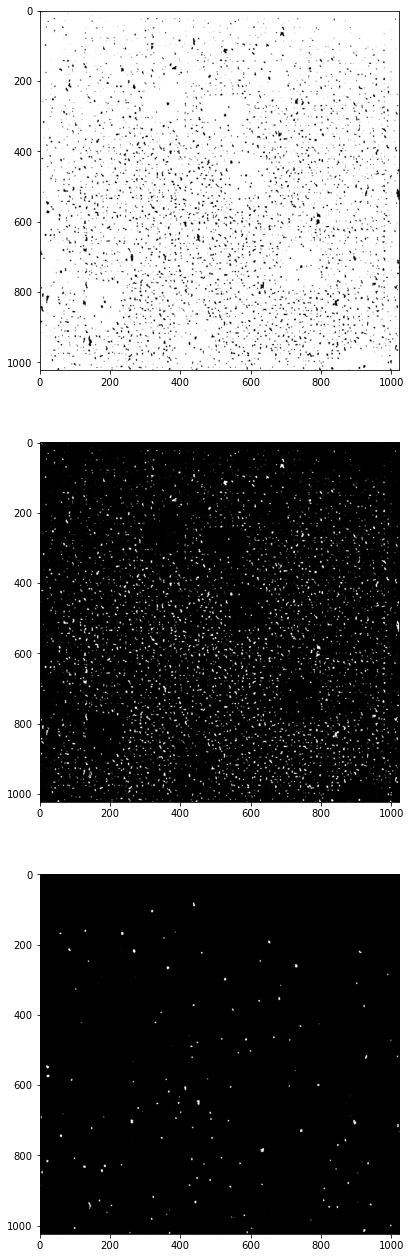

In [13]:
folder_path = 'E:\\raw output'
im_stack = get_image_stack(
    outputs=[[1,0],[2,1]], 
    folder_path=folder_path, 
    frame_im0=16, 
    im_size_width=1024, 
    im_size_height=1024,
    im_resize_width=1024, 
    im_resize_height=1024,
    function_img=[],
    function_diff=[normalize_image])
plot_image_stack(im_stack)
plot_prediction(model=model, im_stack=im_stack)

When the prediction of the network is satisfactory we can extract the positions from the predictions using extract_positions. The function shares its inputs with im_stack with the addition of no_of_frames, model, layer, value_threshold and prediction_size. no_of_frames decides the number of frames to be analyzed and model is the trained network. layer is the segmentation layer from which we will extract the positions, in this example the large particles are on layer 2. value_threshold is the minimum value a pixel can have for it to be considered a plankton pixel. prediction_size is the maximum number of pixels a blob can have to be considered background.

To see which predictions were extracted we can use plot_found_positions. Using this function we can optimize the parameters value_threshold and predictions_size to filter out noise.

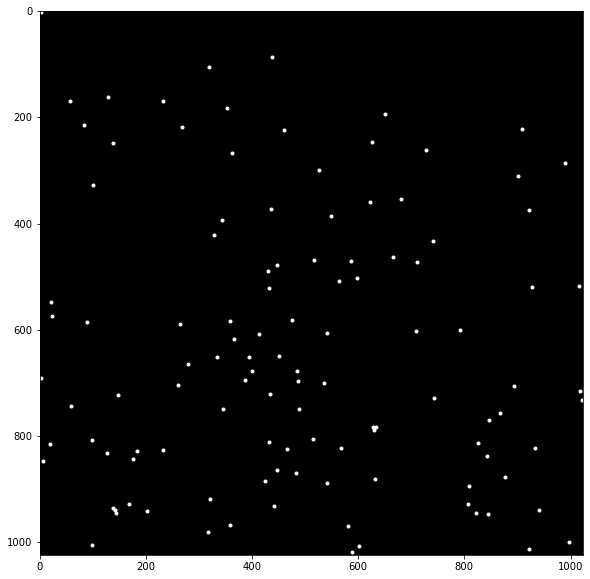

In [14]:
positions = extract_positions(
    no_of_frames=10, 
    outputs=[[1,0],[2,1]], 
    folder_path=folder_path, 
    frame_im0=16, 
    im_size_width=1024, 
    im_size_height=1024,
    im_resize_width=1024, 
    im_resize_height=1024,
    model=model, 
    layer=2, 
    value_threshold=0.95,
    predictions_size=0,
    function_diff=[normalize_image])

plot_found_positions(positions, width=1024, height=1024)

When we have our list of positions it's time to create traces with them, to do this we use the function assign_positions_to_planktons. The inputs are the found positions, max_dist, threshold and a bolean for extrapolation. max_dist is a maximum search radius from its latest position within which the algorithm will assign a found position to a plankton. If more than one is found the algorithm will chose the position that maintains the plankton's mean velocity. The parameter time_threshold sets the maximum number of time steps back in time the algorithm will search for a position if there are recent time steps where no positions were found for it. If extrapolate is set to True the algorithm will extrapolate a new position based on the previous two and look for new positions around that one. The output is a list of plankton where each plankton contains an array of positions.

If a plankton has gaps in its list of positions the function interpolate_gaps_in_plankton_positions will fill these if they only last for one timestep.The input and output is the list of plankton

If there are plankton that are stationary or move too slow they can be filtered using the function trim_list_from_stationary_planktons. The inputs are the list of plankton and a minimum total distance a plankton can travel throughout it's found positions.

To further trim the list of plankton we can divide it into two lists of plankton depending on what fraction of the frames they are present in with the function split_plankton. The inputs are percentage_threshold which is this fraction, and the list of plankton.

In [15]:
list_of_plankton = assign_positions_to_planktons(
    positions, max_dist=15, time_threshold=5, extrapolate=True)

list_of_plankton = interpolate_gaps_in_plankton_positions(
    list_of_plankton=list_of_plankton)

list_of_plankton = trim_list_from_stationary_planktons(
    list_of_plankton=list_of_plankton, min_distance=2)

plankton_track, plankton_dont_track = split_plankton(
    percentage_threshold=0.5, list_of_plankton=list_of_plankton)

Finally we can plot the found positions onto the images that was analyzed, this is done using the function plot_and_save_track. The inputs are can be found in the paper. im_size_width and im_size_height here are used to rescale the found positions to the dimensions of the video. In this case we reshape the video to the dimensions 1024x1024.

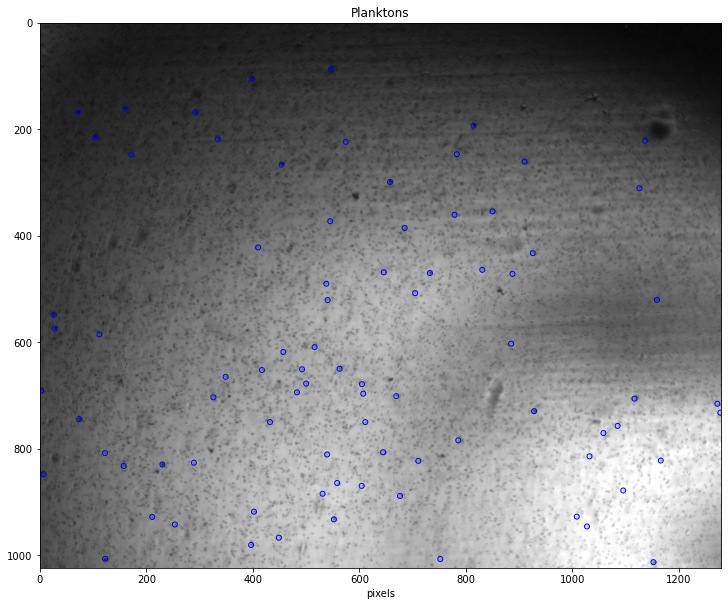

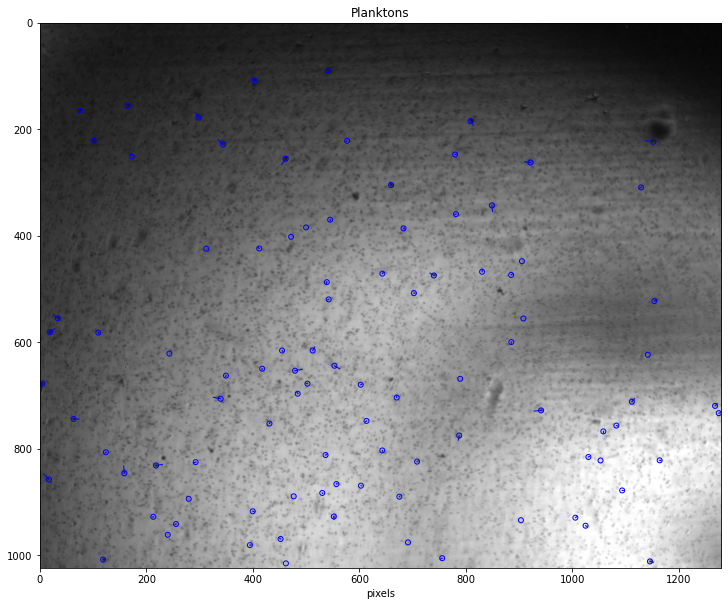

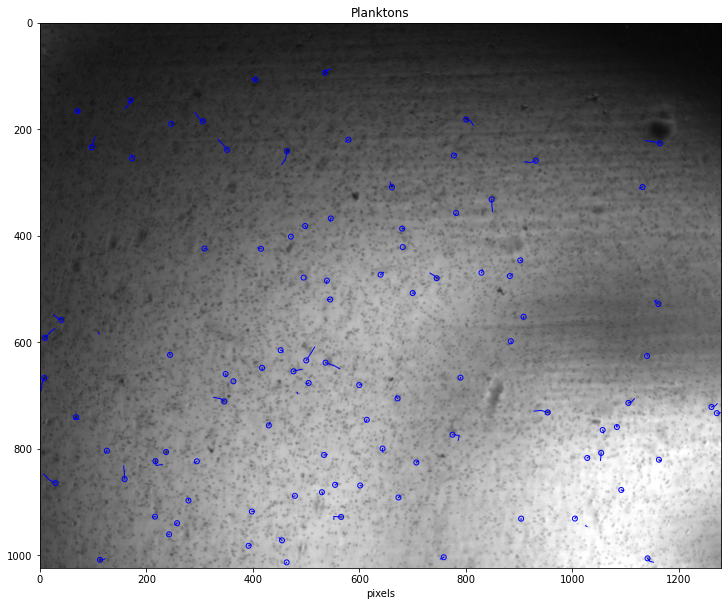

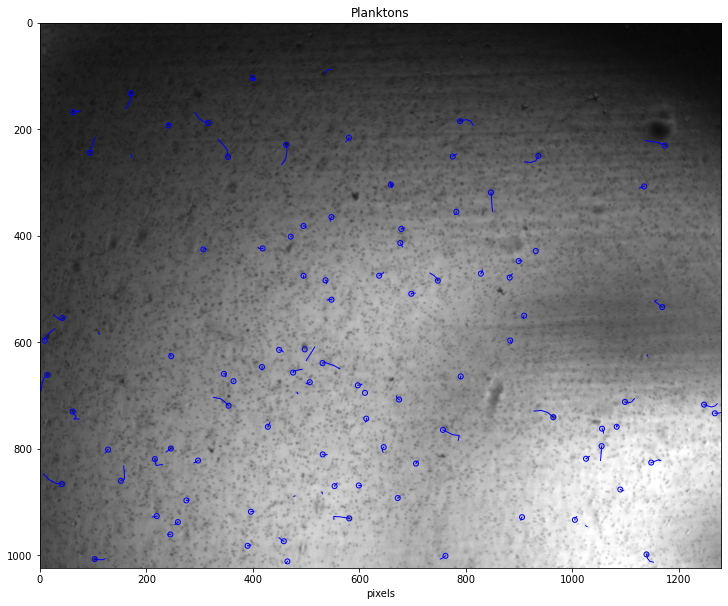

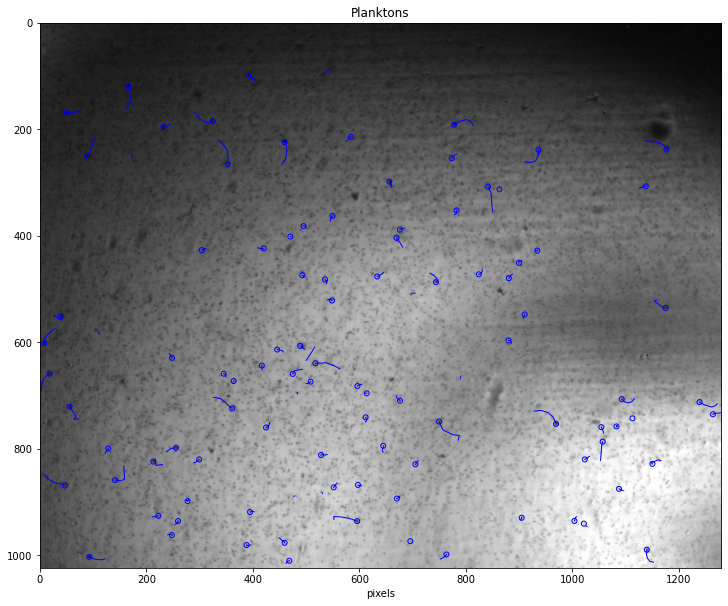

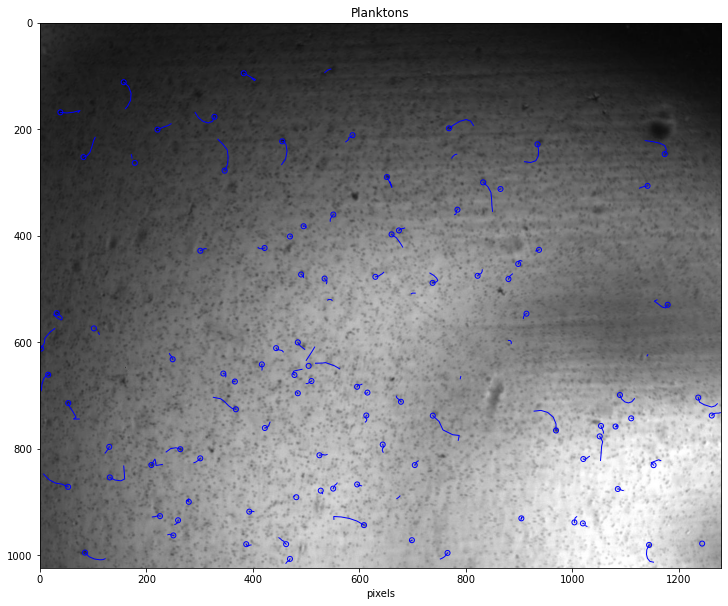

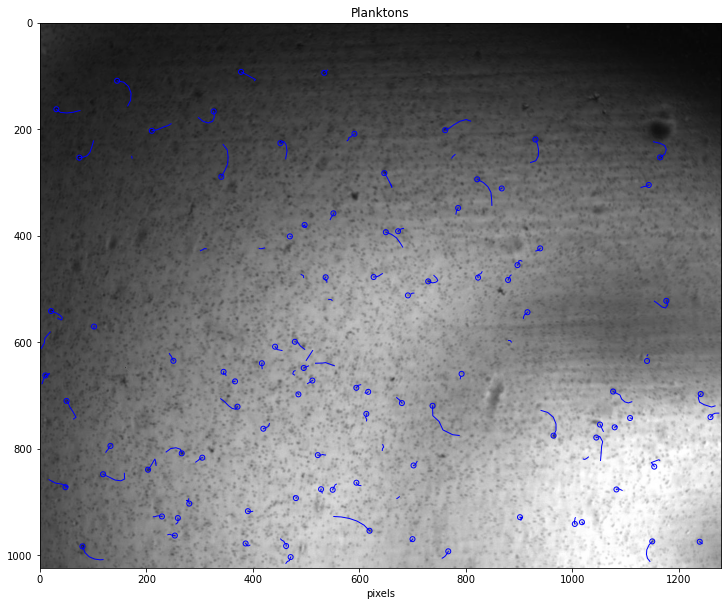

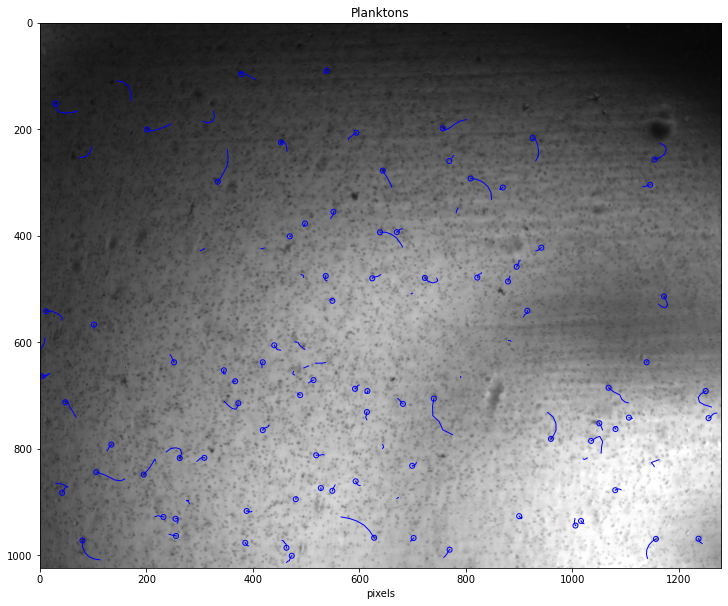

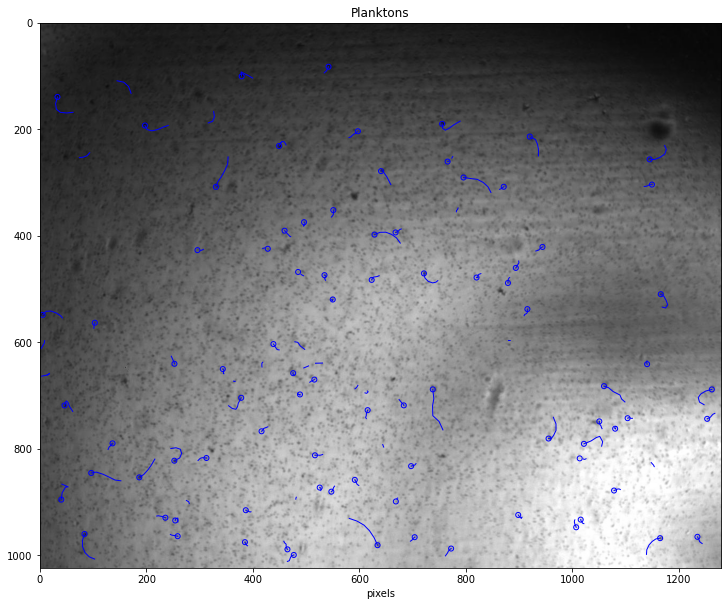

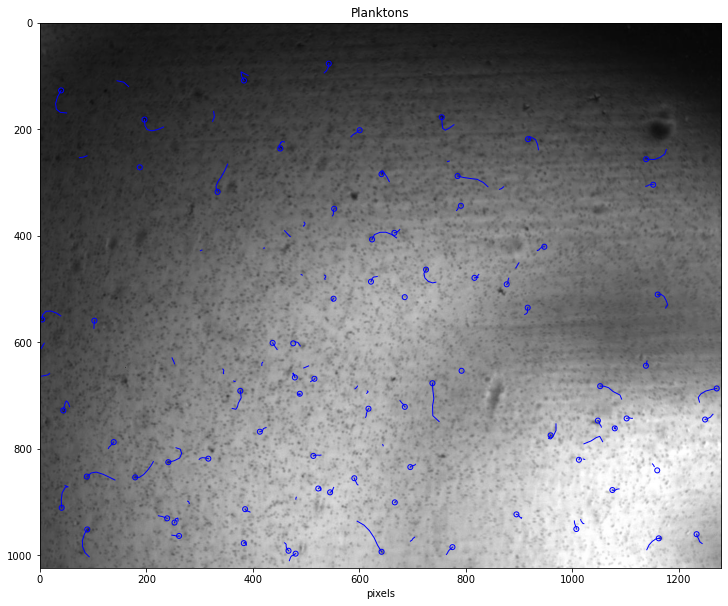

In [16]:
plot_and_save_track(no_of_frames=10,
                    plankton_track=plankton_track,
                    plankton_dont_track=plankton_dont_track,
                    folder_path=folder_path,
                    frame_im0=17,
                    save_images=0,
                    show_plankton_track=True,
                    show_plankton_dont_track=False,
                    show_numbers_track=0,
                    show_numbers_dont_track=0,
                    show_numbers_specific_plankton=False,
                    show_specific_plankton=False,
                    specific_plankton=None,
                    im_size_width=1024, 
                    im_size_height=1024,
                    color_plankton_track='b',
                    color_plankton_dont_track='r',
                    color_specific_plankton='w',
                    save_path='E:\\Documents\\Raw_output',
                    frame_name='track',
                    file_type='.jpg')

We can also create a video with the saved images using Make_video.

In [17]:
# make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Raw_output', 
#            save_path='E:\\Documents\\Differences.avi', 
#            fps=7, 
#            no_of_frames=10)